## 0. Import libraries

In [1]:

# basic libs
import os
import numpy as np
import datetime
import math

# data processing libs
import rasterio as rio
import xarray as xr
import rioxarray
import json
import requests
from pyproj import CRS
from osgeo import gdal
from scipy.interpolate import griddata
import fiona
import netCDF4
# from geojson import Feature, FeatureCollection, dump

# plotting libs
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import odc.stac
import planetary_computer
import pystac_client
import rich.table

input_path = r"G:\Shared drives\Ryoko and Hilary\SMSigxSMAP\analysis\1_data"
SMAPL3_path = r".\SPL3SMP_E"
SMAPL4_path = r".\SPL4SMGP"
MODIS_path = r".\MOD15A2H"

## 1. Get EASE grid

In [2]:
fn = "SMAP_L4_SM_lmc_00000000T000000_Vv7032_001.h5"

file_path = os.path.join(input_path, SMAPL4_path, fn)
if os.path.exists(file_path):
    print('The file exists')

g = gdal.Open(file_path)
subdatasets = g.GetSubDatasets()

varname_lat = "cell_lat"
full_varname_lat = f'HDF5:"{file_path}"://{varname_lat}'

varname_lon = "cell_lon"
full_varname_lon = f'HDF5:"{file_path}"://{varname_lon}'

varname_ease_column = "cell_column"
full_varname_ease_column = f'HDF5:"{file_path}"://{varname_ease_column}'

varname_ease_row = "cell_row"
full_varname_ease_row = f'HDF5:"{file_path}"://{varname_ease_row}'

lat = rioxarray.open_rasterio(full_varname_lat)
lon = rioxarray.open_rasterio(full_varname_lon)
ease_column = rioxarray.open_rasterio(full_varname_ease_column)
ease_row = rioxarray.open_rasterio(full_varname_ease_row)


The file exists


c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\flipl\anaconda3\envs\SMAP\lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.wa

In [3]:
target_lat = -35.32395
target_lon = 147.5348

distance = np.sqrt((target_lat-lat[0].values)**2+(target_lon-lon[0].values)**2)

minElement  = np.where(abs(distance) == np.nanmin(abs(distance)))
print(np.nanmin(distance))

if len(minElement[0])!=1:
    print('There are more than two closest cells')
    
lat_center = lat[0].values[minElement]
lon_center = lon[0].values[minElement]
ease_center_column = ease_column[0].values[minElement]
ease_center_row = ease_row[0].values[minElement]

print(f'The closest cell to the point ({target_lat}, {target_lon}) is\
      ({lat_center[0]}, {lon_center[0]}:\
      EASE GRID ({ease_center_row[0]}, {ease_center_column[0]})),\
      d={distance[minElement]} degrees')


0.038834024
The closest cell to the point (-35.32395, 147.5348) is      (-35.29212188720703, 147.5570526123047:      EASE GRID (1281, 3508)),      d=[0.03883402] degrees


In [4]:
bbox_lat_min = (lat[0].values[minElement]+lat[0].values[minElement[0][0]+1][minElement[1][0]])/2
bbox_lat_max = (lat[0].values[minElement]+lat[0].values[minElement[0][0]-1][minElement[1][0]])/2
bbox_lon_max = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]+1])/2
bbox_lon_min = (lon[0].values[minElement]+lon[0].values[minElement[0][0]][minElement[1][0]-1])/2

bounding_box = f'{bbox_lon_min[0]},{bbox_lat_min[0]},{bbox_lon_max[0]},{bbox_lat_max[0]}'
print(bounding_box)

# bbox_lon_min = 
# bbox_lon_max = 
# bbox_lat_min = 


147.5103759765625,-35.335205078125,147.60372924804688,-35.24908447265625


## 2. GET corresponding SMAP L3 data 

### Get granule

In [5]:
# https://docs.xarray.dev/en/stable/user-guide/data-structures.html
# latitude: Latitude of the center of a 9 km EASE-Grid  2.0 cell.

my_credential_path = "../0_code/auth.json"
with open(my_credential_path, 'r') as infile:
    my_credentials = json.load(infile)
    
uid = my_credentials['username'] # Enter Earthdata Login user name
pswd = my_credentials['password'] # Enter Earthdata Login password
email = my_credentials['email'] # Enter Earthdata login email 

In [6]:
short_name = 'SPL3SMP_E'
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

versions = [el['version_id'] for el in results['feed']['entry']]
latest_version = max(versions)
print('The most recent version of ', short_name, ' is ', latest_version)

 #input('Input spatial coordinates in the following order: lower left longitude,lower left latitude,upper right longitude,upper right latitude. Leave blank if you wish to provide a vector-based spatial file for ICESat-2 search and subsetting:')
start_date = '2015-03-31'# input('Input start date in yyyy-MM-dd format: ')
start_time = '00:00:00' # input('Input start time in HH:mm:ss format: ')
end_date = '2016-03-30' # input('Input end date in yyyy-MM-dd format: ')
end_time = '00:00:00' # input('Input end time in HH:mm:ss format: ')


The most recent version of  SPL3SMP_E  is  005


In [7]:
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
aoi='1'
if aoi == '1':
# bounding box input:
    search_params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }

granules = []
headers={'Accept': 'application/json'}
while True:
    response = requests.get(granule_search_url, params=search_params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    search_params['page_num'] += 1

print('There are', len(granules), 'granules of', short_name, 'version', latest_version, 'over my area and time of interest.')

There are 364 granules of SPL3SMP_E version 005 over my area and time of interest.


### Read the data 

In [8]:
# i = 55
fn ='SMAP_L3_SM_P_E_20191021_R18290_001_HEGOUT.nc'
# TODO: redownload the data with latitude_pm and longitude_pm, also easegrid_(column, row)_pm and easegrid_(column, row)_am 
file_path = os.path.join(input_path, SMAPL3_path, fn)
if os.path.exists(file_path):
    print('The file exists')
else:
    print(f"The file {file_path} doesn't exist")

SMAPL3 = rioxarray.open_rasterio(file_path)
samplePoint_SMAP = SMAPL3.rio.clip_box(
    minx=bbox_lon_min,
    miny=bbox_lat_min,
    maxx=bbox_lon_max,
    maxy=bbox_lat_max,
    crs="EPSG:4326",
    auto_expand_limit = 1
).copy()
    

The file exists


In [9]:
print(samplePoint_SMAP.x.values)
print(samplePoint_SMAP.y.values)
# 147.5103759765625,-35.335205078125,147.60372924804688,-35.24908447265625

[147.55704555 147.65040654]
[-35.25113781 -35.34449881]


## 3. Get MODIS data

## 

In [22]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

from math import ceil, floor
def float_round(num, places = 0, direction = floor):
    return direction(num * (10**places)) / float(10**places)

bbox = [bbox_lon_min[0]-buffer, bbox_lat_min[0]-buffer, bbox_lon_max[0]+buffer, bbox_lat_max[0]+buffer]
bbox = [float_round(x, 10, round)for x in bbox] 
print(bbox)
year = "2019"
months = {
    "February": "2",
}

time_range = "2019-03-01/2019-03-31"

search = catalog.search(
    collections=["modis-15A3H-061"],
    bbox=bbox,
    datetime=time_range,
)
items = list(search.get_items())
print(f"Found: {len(items):d} datasets")

# items_dict = dict()
# for i, item in enumerate(items):
#     items_dict[i] = item
# items_dict = dict()  
# items_dict[0] = items[0]
# print(items_dict.values())

t = rich.table.Table("Key", "Title")
for key, asset in items[0].assets.items():
    t.add_row(key, asset.title)
t

[147.0103759766, -35.8352050781, 148.103729248, -34.7490844727]
Found: 18 datasets


┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key              ┃ Title                                             ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hdf              │ Source data containing all bands                  │
│ Lai_500m         │ Leaf Area Index                                   │
│ metadata         │ Federal Geographic Data Committee (FGDC) Metadata │
│ Fpar_500m        │ Fraction of Photosynthetically Active Radiation   │
│ FparLai_QC       │ Quality for FPAR and LAI                          │
│ FparExtra_QC     │ Extra detail Quality for FPAR and LAI             │
│ LaiStdDev_500m   │ Standard deviation of LAI                         │
│ FparStdDev_500m  │ Standard deviation of FPAR                        │
│ tilejson         │ TileJSON with default rendering                   │
│ rendered_preview │ Rendered preview                                  │
└──────────────────┴───────────────────────────────────────────────────┘

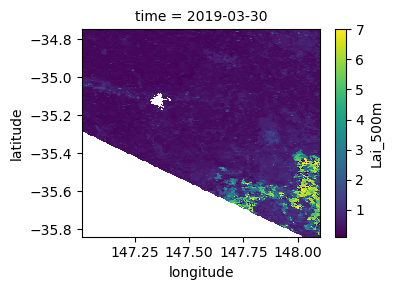

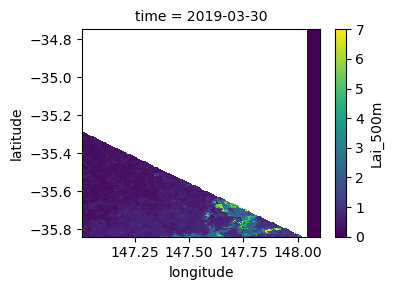

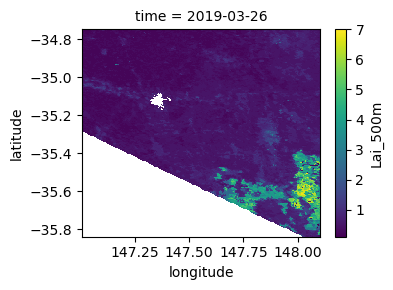

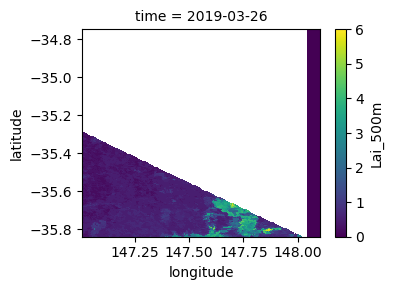

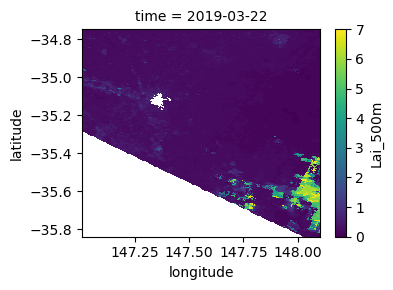

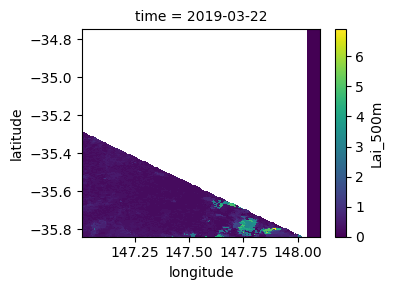

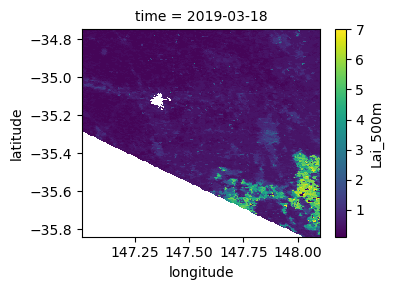

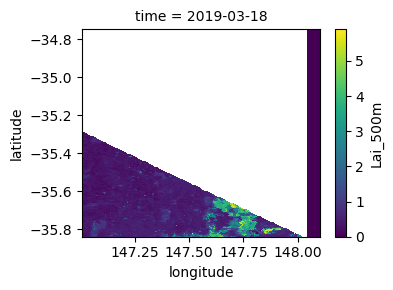

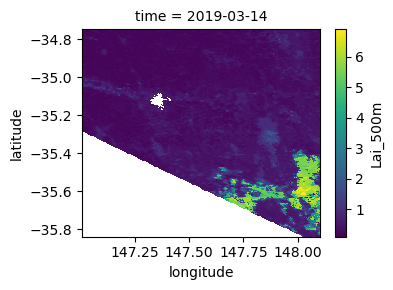

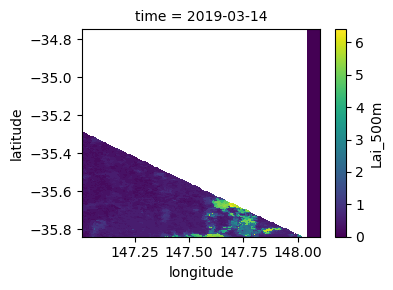

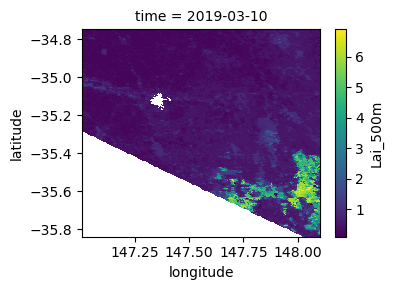

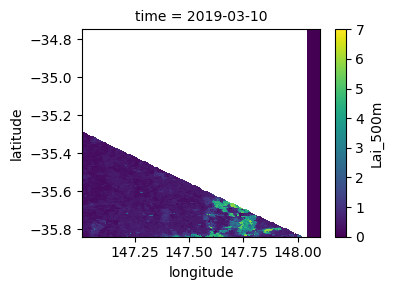

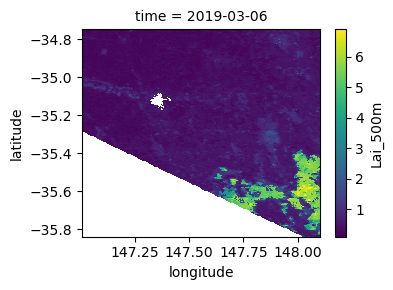

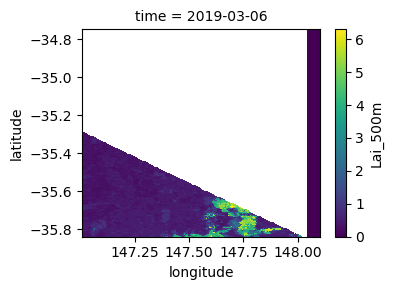

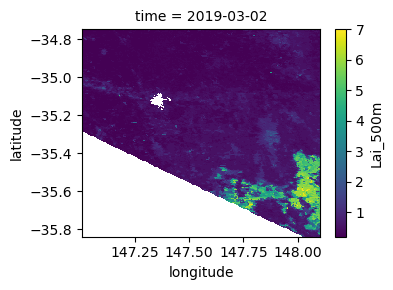

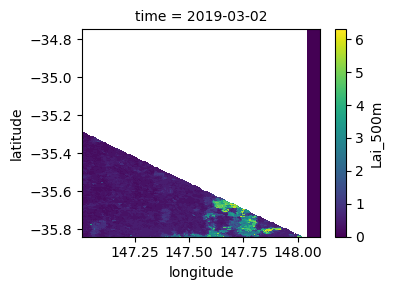

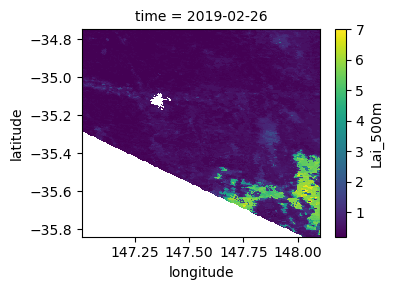

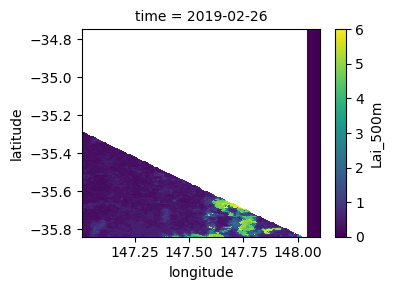

In [23]:
from odc.stac import stac_load


for i in range(len(items)):
    data0 = stac_load(
        [items[i]],
        crs="EPSG:4326",
        bands="Lai_500m",
        resolution=0.0045,
        bbox=bbox
    )
    raster = items[i].assets["Lai_500m"].extra_fields["raster:bands"]
    data = data0["Lai_500m"] * raster[0]["scale"]
    data.values[data.values >=24.9] = np.nan
    data.plot.imshow(cmap="viridis", col="time")

# TODO: combine two rasters for the same dates 
# TODO: resample to SMAP grid



In [14]:
data0

<xarray.Dataset>
Dimensions:      (latitude: 2223, longitude: 9486, time: 9)
Coordinates:
  * latitude     (latitude) float64 -30.0 -30.0 -30.01 ... -39.99 -39.99 -40.0
  * longitude    (longitude) float64 127.0 127.0 127.0 ... 169.7 169.7 169.7
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-02-26 2019-03-02 ... 2019-03-30
Data variables:
    Lai_500m     (time, latitude, longitude) uint8 255 255 255 ... 254 254 255

## Read SMAP L4 data

## Resample SMAP L4 data 

## Plot SMAP L4 data

In [2]:
## 

## Get and read MODIS LAI data 

## Resample MODIS LAI data

## Plot MODIS LAI data

## Repeat the analysis to get the timeseries of data (probably rewrite to python code)

## Get Ltheta with LAI 